In [69]:
from __future__ import print_function
from skimage.io import imread
import cv2
import numpy as np
import math
from PIL import Image
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, filters
from skimage.feature import hog
from skimage import data, exposure
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Harris Detector

In [5]:
def convolve_Sobel(img):
    
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = convolve2d(img, kernel_x, mode='same')
    Iy = convolve2d(img, kernel_y, mode='same')
    
    return Ix, Iy

In [54]:
def convolve_Sobel(img):
    
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = convolve2d(img, kernel_x, mode='same')
    Iy = convolve2d(img, kernel_y, mode='same')
    
    return Ix, Iy

def harris_corner_detector(img):
    
    m, n = img.shape
    thresh = 10**7
    
    Ix, Iy = convolve_Sobel(img)
    
    Ixx = gaussian_filter(Ix**2, sigma=1)
    Ixy = gaussian_filter(Ix*Iy, sigma=1)
    Iyy = gaussian_filter(Iy**2, sigma=1)
    
    k = 0.05
    detH = Ixx*Iyy - Ixy**2
    traceH = Ixx + Iyy
    
    R = detH - k*(traceH**2)
    
    img_corners = np.zeros((m,n))
    for i in range(1, m-1):
        for j in range(1, n-1):
            if R[i,j] > thresh and R[i, j] > R[i - 1, j - 1] and R[i, j] > R[i - 1, j + 1] and R[i, j] > R[i + 1, j - 1] and R[i, j] > R[i + 1, j + 1]:
                img_corners[i,j] = 255
    return img_corners

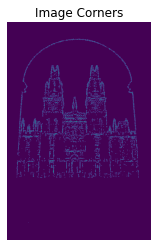

In [55]:
img   = cv2.imread('all_souls_000002.jpg')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_corners = harris_corner_detector(img)

plt.imshow(img_corners)
plt.axis('off')
plt.title('Image Corners')
plt.show()

In [56]:
print(np.where(img_corners > 0))

(array([ 79,  79,  79, ..., 731, 731, 942], dtype=int64), array([312, 313, 339, ..., 396, 400, 100], dtype=int64))


In [57]:
def storing_corners(img_corners, scale):
    x_list = np.where(img_corners > 0)[0]
    y_list = np.where(img_corners > 0)[1]
    scale_list = scale*np.array([1 for i in range(len(x_list))])
    return np.vstack((x_list, y_list, scale_list)).T

In [58]:
corners_list = storing_corners(img_corners, 1)
print(corners_list.shape)
print(corners_list[0])

(10487, 3)
[ 79 312   1]


In [59]:
def bilinear_interpolation(delta_s, img):
    n, p = img.shape[0], img.shape[1]
    resized = cv2.resize(img, (int(delta_s*p),int(delta_s*n)), interpolation=cv2.INTER_LINEAR)
    return resized

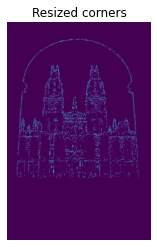

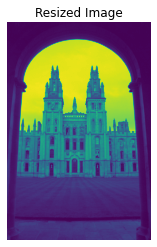

In [60]:
resized_img = bilinear_interpolation(0.5, img)
resized_corners = bilinear_interpolation(0.5, img_corners)

plt.imshow(resized_corners)
plt.axis('off')
plt.title('Resized corners')
plt.show()

plt.imshow(resized_img)
plt.axis('off')
plt.title('Resized Image')
plt.show()

In [61]:
corners_list_resized = storing_corners(resized_corners, 0.5)
print(corners_list_resized.shape)

(7790, 3)


(3838, 3)


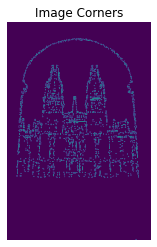

In [62]:
corners_resized = harris_corner_detector(resized_img)
corners = storing_corners(corners_resized, 0.5)
print(corners.shape)
plt.imshow(corners_resized)
plt.axis('off')
plt.title('Image Corners')
plt.show()

In [63]:
def generate_keypoints(delta_s, num_ocatves, img):
    scale = 1
    img_corners = harris_corner_detector(img)
    corners = storing_corners(img_corners, scale)
    keypoints = [corners]
    for i in range(1, num_ocatves):
        scale = scale*delta_s
        img = bilinear_interpolation(delta_s, img)
        img_corners = harris_corner_detector(img)
        corners = storing_corners(img_corners, scale)
        keypoints.append(corners)
    return np.array(keypoints)

In [64]:
img   = cv2.imread('all_souls_000002.jpg')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
delta_s, num_ocatves = 0.75, 4

init_keypoints = generate_keypoints(delta_s, num_ocatves, img)

In [65]:
print(init_keypoints[0].shape)
print(init_keypoints[1].shape)
print(init_keypoints[2].shape)
print(init_keypoints[3].shape)
print(init_keypoints[3][0])

(10487, 3)
(6560, 3)
(4138, 3)
(2624, 3)
[ 32.       127.         0.421875]


In [121]:
def get_grad(L, x, y):
    dx = L[min(L.shape[0]-1, x+1),y] - L[max(0, x-1),y]
    dy = L[x,min(L.shape[1]-1, y+1)] - L[x,max(0, y-1)]
    return dx, dy

In [67]:
def magnitude_orient(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

In [74]:
def neighborhood(img, x, y, size):
    # size is an even number
    n, p = img.shape
    N = size//2
    patch = img[max(x-N,0): min(x+N, n),max(y-N,0): min(y+N, p)]
    return patch

In [78]:
x, y = init_keypoints[0][0][0], init_keypoints[0][0][1]
neigh = neighborhood(img, x, y, 16)
print(neigh)

[[ 18  18  19  19  20  19  20  20  18  18  19  20  18  18  20  21]
 [ 18  19  21  20  20  20  22  23  21  22  22  23  24  23  22  23]
 [ 18  19  21  22  20  20  21  22  24  24  22  22  23  23  22  24]
 [ 19  20  21  21  21  20  21  21  22  22  20  19  21  21  21  21]
 [ 20  20  21  21  20  20  21  22  20  21  19  19  21  21  20  19]
 [ 20  20  20  21  21  20  21  23  20  21  22  21  22  23  21  21]
 [ 20  20  21  22  22  21  21  22  23  23  23  23  23  22  21  22]
 [ 22  21  22  23  23  22  22  23  23  23  24  23  23  21  21  24]
 [ 25  24  23  24  23  23  23  25  24  24  25  27  27  24  24  28]
 [ 28  26  26  27  27  24  25  27  25  25  22  26  27  29  27  38]
 [ 27  30  32  35  42  50  58  63  76  88 100 116 124 136 145 164]
 [122 140 163 179 191 203 213 218 233 236 236 239 240 242 238 243]
 [241 243 241 239 237 237 236 235 230 230 228 227 227 227 223 223]
 [226 226 226 225 227 228 228 227 228 229 229 228 227 229 229 231]
 [228 230 232 232 230 228 229 231 230 229 230 229 228 231 228 

In [145]:
def gaussian(x,y,sigma):
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))

In [154]:
def gaussian_filter(sigma):
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = gaussian(x, y, sigma)
    return g/g.sum()

In [153]:
print(gaussian(200,500,1))

0.0


In [159]:
def assign_orientation(keypoints, img_resized, w = 16, bins = 36):
    L = img_resized
    new_kp = []
    for kp in keypoints:
        # sigma = float(kp[2])*1.5
        x, y = int(kp[0]), int(kp[1])
        hist = np.zeros((bins,1))
        patch = neighborhood(L, x, y, w)
        for i in range(int(w//2)):
            for j in range(int(w//2)):
                dx1, dy1 = get_grad(L, x+i, y+j)
                dx2, dy2 = get_grad(L, x+i, y-j)
                dx3, dy3 = get_grad(L, x-i, y-j)
                dx4, dy4 = get_grad(L, x-i, y+j)

                m1, theta1 = magnitude_orient(dx1, dy1)
                m2, theta2 = magnitude_orient(dx1, dy1)
                m3, theta3 = magnitude_orient(dx1, dy1)
                m4, theta4 = magnitude_orient(dx1, dy1)
                ind1, ind2, ind3, ind4 = int(theta1//bins), int(theta2//bins), int(theta3//bins), int(theta4//bins)
                hist[ind1] += m1
                hist[ind2] += m2
                hist[ind3] += m3
                hist[ind4] += m4

        grad, orient = np.amax(hist), np.argmax(hist)*bins
        new_kp.append(np.array([x, y, grad/np.sum(hist), orient]))
    return new_kp

In [160]:
new_kpts = assign_orientation(init_keypoints[0], img, w = 16, bins = 36)

In [161]:
print(new_kpts[0])

[ 79.         312.           0.43834287 180.        ]


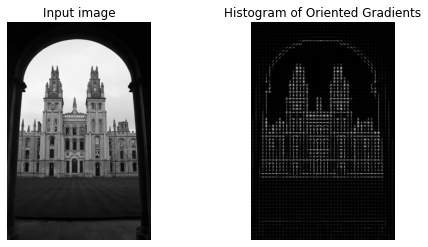

In [71]:
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()